In [54]:
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas
from shapely.geometry import Point

In [55]:
#access data from city of chicago API and convert request data to pandas dataframe

In [56]:
#get 2017 and 2018 crime data
client = Socrata("data.cityofchicago.org", "HfV6h8Xj9GdgDGkPS9JEkKvlp")
crimes_id = "6zsd-86xi"
response_crimes = client.get(crimes_id, where="year between 2017 and 2018", limit=800000)
crimes_2017_2018_df = pd.DataFrame.from_records(response_crimes)

In [57]:
#get community area name data
community_area_id = "igwz-8jzy"
response_cas = client.get(community_area_id)
community_areas_df = pd.DataFrame.from_records(response_cas)
community_areas_df['community_area'] = community_areas_df['area_num_1']
community_areas_to_merge = community_areas_df[['community_area', 'community']]

In [58]:
#merging in community area names
crime_with_cas = pd.merge(crimes_2017_2018_df, community_areas_to_merge, on="community_area")
#checking NAs in variables
crime_with_cas.isna().any()

arrest                  False
beat                    False
block                   False
case_number             False
community_area          False
date                    False
description             False
district                 True
domestic                False
fbi_code                False
id                      False
iucr                    False
latitude                 True
location                 True
location_description     True
longitude                True
primary_type            False
updated_on              False
ward                     True
x_coordinate             True
y_coordinate             True
year                    False
community               False
dtype: bool

In [59]:
#since there are no NAs in the primary type variable I can use size to determine the counts
crime_by_type = crime_with_cas.groupby('primary_type').size().reset_index(name="count")
crime_by_type['percent'] = crime_by_type['count']/crimes_2017_2018_df.shape[0]
crime_by_type.sort_values(by = 'percent', ascending=False)

,primary_type,count,percent
30,THEFT,129427,0.242205
2,BATTERY,98995,0.185256
6,CRIMINAL DAMAGE,56848,0.106383
1,ASSAULT,39678,0.074252
8,DECEPTIVE PRACTICE,37759,0.070661
23,OTHER OFFENSE,34357,0.064294
3,BURGLARY,24731,0.046281
17,NARCOTICS,24645,0.046120
27,ROBBERY,21560,0.040347
16,MOTOR VEHICLE THEFT,21393,0.040034


In [60]:
#what percentage of crimes result in an arrest?

In [61]:
grouped_arrest = crime_with_cas.groupby('arrest').size()/crime_with_cas.shape[0]
grouped_arrest

arrest
False    0.803586
True     0.196414
dtype: float64

In [62]:
#how seasonal are crimes? has the crime rate gone down over time?

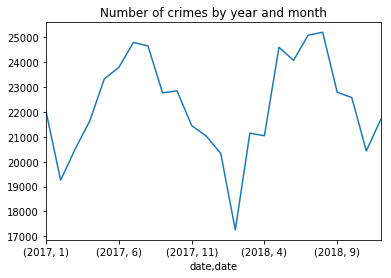

In [63]:
crime_by_month = crime_with_cas.groupby([pd.to_datetime(crime_with_cas['date']).dt.year, pd.to_datetime(crime_with_cas['date']).dt.month]).size()
crime_by_month.plot(kind="line", title= "Number of crimes by year and month")
#fix axis

In [64]:
#how do the number of crimes differ by community area?

In [65]:
crime_by_area = crime_with_cas.groupby('community').size().reset_index(name="count")
crime_by_area.sort_values(by='count', ascending=False)

,community,count
5,AUSTIN,30429
47,NEAR NORTH SIDE,25367
41,LOOP,21480
49,NEAR WEST SIDE,18448
52,NORTH LAWNDALE,18377
65,SOUTH SHORE,17325
32,HUMBOLDT PARK,16095
75,WEST TOWN,15625
4,AUBURN GRESHAM,14897
70,WEST ENGLEWOOD,14016


In [66]:
#arrest by area, also maybe do top crimes by area

In [67]:
#use geopandas and make maps

In [68]:
#adding in census data now

In [69]:
#https://api.census.gov/data/2017/acs/acs5/subject?get=NAME,group(S0101)&for=us:1

In [70]:
#number of households
#total all: B03002_001E
#total not hispanic: B03002_002E
#total white alone: B03002_003E
#total black alone: B03002_004E
#total asian alone: B03002_006E

#number of households who received food stamps or SNAP benefits
#total: B22003_001E
#yes: #B22003_002E
#no: #B22003_005E

#owner occupied or renter occupied households
#owner occupied: #B25003_002E
#renter occupied: #B25003_003E
#tenure total: #B25003_001E

In [71]:
response_acs = requests.get("https://api.census.gov/data/2017/acs/acs5?get=NAME,B03002_001E,B03002_012E,B03002_003E,B03002_004E,B19013_001E,B11016_001E,B25003_003E&for=block%20group:*&in=state:17%20county:031&key=faa9380c4c99556827d85c391d21845b8c4629c5")

In [72]:
acs_df = pd.DataFrame.from_records(response_acs.json())
#rename column names
#need to set first row as headers and replace
acs_df.columns = acs_df.iloc[0]
acs_df = acs_df[1:]

acs_df = acs_df.rename({
             'B03002_001E': 'total_race', 
             'B03002_012E': 'hispanic', 
             'B03002_003E': 'white', 
             'B03002_004E': 'black', 
             'B19013_001E': 'household_income',
             'B11016_001E': 'households_total',
             'B25003_003E': 'renter-occupied'
             }, axis='columns')

#need to make geoid to join with crimes data

acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract'] + acs_df['block group']

In [73]:
acs_df

,NAME,total_race,hispanic,white,black,household_income,households_total,renter-occupied,state,county,tract,block group,GEOID
1,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,251900,1,170312519001
2,"Block Group 2, Census Tract 2519, Cook County,...",1546,92,78,1376,32143,402,275,17,031,251900,2,170312519002
3,"Block Group 1, Census Tract 8211.01, Cook Coun...",1341,598,712,23,57000,448,21,17,031,821101,1,170318211011
4,"Block Group 3, Census Tract 8211.01, Cook Coun...",1356,456,778,48,65699,357,111,17,031,821101,3,170318211013
5,"Block Group 2, Census Tract 8211.01, Cook Coun...",616,17,599,0,97656,269,0,17,031,821101,2,170318211012
6,"Block Group 4, Census Tract 8211.01, Cook Coun...",1193,329,774,0,68826,329,105,17,031,821101,4,170318211014
7,"Block Group 1, Census Tract 8202.02, Cook Coun...",2054,1092,886,22,49609,655,281,17,031,820202,1,170318202021
8,"Block Group 3, Census Tract 8202.02, Cook Coun...",558,110,434,7,48417,235,70,17,031,820202,3,170318202023
9,"Block Group 2, Census Tract 8202.02, Cook Coun...",752,114,634,4,48214,368,76,17,031,820202,2,170318202022
10,"Block Group 4, Census Tract 8203, Cook County,...",1700,1423,232,45,57432,465,182,17,031,820300,4,170318203004


In [74]:
acs_df['pct_hispanic'] = acs_df['hispanic'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_white'] = acs_df['white'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_black'] = acs_df['black'].astype(float)/acs_df['total_race'].astype(float)
acs_df['pct_renter'] = acs_df['renter-occupied'].astype(float)/acs_df['households_total'].astype(float)

In [75]:
#get block groups shapefile through city of chicago

In [76]:
#read in the shapefile

In [77]:
chicago_shapefile = "/users/bhargaviganesh/Documents/ml_spring19/assignment1/Boundaries-CensusBlocks-2010/geo_export_af8343ba-c982-427f-a0f3-3a8326fb75ca.shp"
blocks_df = geopandas.read_file(chicago_shapefile)
blocks_df['GEOID'] = blocks_df['geoid10'].str.slice(start=0, stop=12)
acs_merged_with_blocks = pd.merge(acs_df, blocks_df, on="GEOID")

In [78]:
acs_merged_with_blocks

,NAME,total_race,hispanic,white,black,household_income,households_total,renter-occupied,state,county,...,pct_black,pct_renter,blockce10,countyfp10,geoid10,name10,statefp10,tract_bloc,tractce10,geometry
0,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1015,031,170312519001015,Block 1015,17,2519001015,251900,POLYGON ((-87.76013899978788 41.88085499998754...
1,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1012,031,170312519001012,Block 1012,17,2519001012,251900,POLYGON ((-87.75948099998418 41.88183699942084...
2,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1000,031,170312519001000,Block 1000,17,2519001000,251900,POLYGON ((-87.75899400052153 41.88727599983122...
3,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1014,031,170312519001014,Block 1014,17,2519001014,251900,"POLYGON ((-87.7601720008503 41.88183400017517,..."
4,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1011,031,170312519001011,Block 1011,17,2519001011,251900,POLYGON ((-87.75948099998418 41.88183699942084...
5,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1004,031,170312519001004,Block 1004,17,2519001004,251900,POLYGON ((-87.75959300005599 41.88575499972903...
6,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1008,031,170312519001008,Block 1008,17,2519001008,251900,POLYGON ((-87.75952200044817 41.88278400000262...
7,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1005,031,170312519001005,Block 1005,17,2519001005,251900,"POLYGON ((-87.759567999757 41.8840029998924, -..."
8,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1003,031,170312519001003,Block 1003,17,2519001003,251900,"POLYGON ((-87.7602989995242 41.88624299967484,..."
9,"Block Group 1, Census Tract 2519, Cook County,...",600,0,11,589,21500,194,53,17,031,...,0.981667,0.273196,1013,031,170312519001013,Block 1013,17,2519001013,251900,POLYGON ((-87.75878799972214 41.88184800025554...


In [79]:
crime_with_cas

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,community
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28T21:43:00.000,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,"{'type': 'Point', 'coordinates': [-87.69463767...",JAIL / LOCK-UP FACILITY,-87.694637678,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017,SOUTH LAWNDALE
1,False,1033,027XX S WHIPPLE ST,JB146365,30,2017-01-01T00:01:00.000,AGG SEX ASSLT OF CHILD FAM MBR,010,False,02,...,NaN,RESIDENCE,NaN,OFFENSE INVOLVING CHILDREN,2018-02-11T15:57:41.000,12,NaN,NaN,2017,SOUTH LAWNDALE
2,False,1013,024XX S HARDING AVE,JB108175,30,2018-01-08T05:55:00.000,TO PROPERTY,010,False,14,...,"{'type': 'Point', 'coordinates': [-87.72340589...",APARTMENT,-87.723405898,CRIMINAL DAMAGE,2018-05-04T15:51:04.000,22,1150432,1887560,2018,SOUTH LAWNDALE
3,False,1032,033XX S KEDZIE AVE,JA541446,30,2017-12-08T03:00:00.000,BY FIRE,010,False,09,...,"{'type': 'Point', 'coordinates': [-87.70468577...","SCHOOL, PRIVATE, BUILDING",-87.704685773,ARSON,2018-03-01T15:54:55.000,22,1155572,1882206,2017,SOUTH LAWNDALE
4,True,1031,027XX S AVERS AVE,JB160133,30,2018-02-22T09:22:00.000,FIRST DEGREE MURDER,010,False,01A,...,"{'type': 'Point', 'coordinates': [-87.72081859...",APARTMENT,-87.720818596,HOMICIDE,2019-03-18T16:08:09.000,22,1151152,1885454,2018,SOUTH LAWNDALE
5,False,1013,023XX S MILLARD AVE,JB169766,30,2017-12-05T12:00:00.000,ILLEGAL USE CASH CARD,010,False,11,...,NaN,RESIDENCE,NaN,DECEPTIVE PRACTICE,2018-03-02T15:54:48.000,22,NaN,NaN,2017,SOUTH LAWNDALE
6,False,1024,024XX S ST LOUIS AVE,JB150851,30,2017-12-09T23:59:00.000,CRIMINAL SEXUAL ABUSE,010,False,17,...,NaN,RESIDENCE,NaN,SEX OFFENSE,2018-02-14T15:52:17.000,22,NaN,NaN,2017,SOUTH LAWNDALE
7,True,1033,022XX S WHIPPLE ST,JA118524,30,2017-01-16T20:05:00.000,PREDATORY,010,True,02,...,"{'type': 'Point', 'coordinates': [-87.70155403...",APARTMENT,-87.70155403,CRIM SEXUAL ASSAULT,2019-03-28T15:59:40.000,12,1156376,1888939,2017,SOUTH LAWNDALE
8,False,1032,026XX S DRAKE AVE,JB558892,30,2018-12-16T19:00:00.000,AGG SEX ASSLT OF CHILD FAM MBR,031,True,02,...,"{'type': 'Point', 'coordinates': [-87.81879610...",RESIDENCE,-87.818796103,OFFENSE INVOLVING CHILDREN,2019-03-27T16:10:11.000,22,1124178,1931354,2018,SOUTH LAWNDALE
9,False,1013,042XX W 24TH PL,JB117618,30,2018-01-16T07:48:00.000,AGGRAVATED: HANDGUN,010,False,04A,...,"{'type': 'Point', 'coordinates': [-87.72990271...",STREET,-87.729902712,ASSAULT,2018-05-04T15:51:04.000,22,1148663,1887385,2018,SOUTH LAWNDALE


In [80]:
#convert to geodataframe
crime_with_cas['Coordinates'] = list(zip(crime_with_cas.longitude.astype(float), crime_with_cas.latitude.astype(float)))
crime_with_cas['Coordinates'] = crime_with_cas['Coordinates'].apply(Point)
crime_gdf = geopandas.GeoDataFrame(crime_with_cas, geometry='Coordinates')
crime_gdf

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,community,Coordinates
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28T21:43:00.000,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,JAIL / LOCK-UP FACILITY,-87.694637678,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017,SOUTH LAWNDALE,POINT (-87.69463767800001 41.843778126)
1,False,1033,027XX S WHIPPLE ST,JB146365,30,2017-01-01T00:01:00.000,AGG SEX ASSLT OF CHILD FAM MBR,010,False,02,...,RESIDENCE,NaN,OFFENSE INVOLVING CHILDREN,2018-02-11T15:57:41.000,12,NaN,NaN,2017,SOUTH LAWNDALE,POINT (nan nan)
2,False,1013,024XX S HARDING AVE,JB108175,30,2018-01-08T05:55:00.000,TO PROPERTY,010,False,14,...,APARTMENT,-87.723405898,CRIMINAL DAMAGE,2018-05-04T15:51:04.000,22,1150432,1887560,2018,SOUTH LAWNDALE,POINT (-87.723405898 41.847364829)
3,False,1032,033XX S KEDZIE AVE,JA541446,30,2017-12-08T03:00:00.000,BY FIRE,010,False,09,...,"SCHOOL, PRIVATE, BUILDING",-87.704685773,ARSON,2018-03-01T15:54:55.000,22,1155572,1882206,2017,SOUTH LAWNDALE,POINT (-87.70468577299999 41.832571089)
4,True,1031,027XX S AVERS AVE,JB160133,30,2018-02-22T09:22:00.000,FIRST DEGREE MURDER,010,False,01A,...,APARTMENT,-87.720818596,HOMICIDE,2019-03-18T16:08:09.000,22,1151152,1885454,2018,SOUTH LAWNDALE,POINT (-87.720818596 41.841571637)
5,False,1013,023XX S MILLARD AVE,JB169766,30,2017-12-05T12:00:00.000,ILLEGAL USE CASH CARD,010,False,11,...,RESIDENCE,NaN,DECEPTIVE PRACTICE,2018-03-02T15:54:48.000,22,NaN,NaN,2017,SOUTH LAWNDALE,POINT (nan nan)
6,False,1024,024XX S ST LOUIS AVE,JB150851,30,2017-12-09T23:59:00.000,CRIMINAL SEXUAL ABUSE,010,False,17,...,RESIDENCE,NaN,SEX OFFENSE,2018-02-14T15:52:17.000,22,NaN,NaN,2017,SOUTH LAWNDALE,POINT (nan nan)
7,True,1033,022XX S WHIPPLE ST,JA118524,30,2017-01-16T20:05:00.000,PREDATORY,010,True,02,...,APARTMENT,-87.70155403,CRIM SEXUAL ASSAULT,2019-03-28T15:59:40.000,12,1156376,1888939,2017,SOUTH LAWNDALE,POINT (-87.70155403 41.851031045)
8,False,1032,026XX S DRAKE AVE,JB558892,30,2018-12-16T19:00:00.000,AGG SEX ASSLT OF CHILD FAM MBR,031,True,02,...,RESIDENCE,-87.818796103,OFFENSE INVOLVING CHILDREN,2019-03-27T16:10:11.000,22,1124178,1931354,2018,SOUTH LAWNDALE,POINT (-87.818796103 41.968013038)
9,False,1013,042XX W 24TH PL,JB117618,30,2018-01-16T07:48:00.000,AGGRAVATED: HANDGUN,010,False,04A,...,STREET,-87.729902712,ASSAULT,2018-05-04T15:51:04.000,22,1148663,1887385,2018,SOUTH LAWNDALE,POINT (-87.729902712 41.8469189)


In [81]:
#set coordinate systems for acs data and blocks data before doing sjoin

In [82]:
crime_gdf.crs = {'init': 'epsg:4326'}
acs_merged_with_blocks.crs = {'init': 'epsg:4326'}

/Users/bhargaviganesh/anaconda3/envs/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [83]:
#now to figure out which blocks the crime data fits in

In [84]:
#remove NA long/lat

In [85]:
crime_gdf_blocks = crime_gdf.dropna(axis=0, subset=['longitude'])

In [86]:
crime_gdf_blocks

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year,community,Coordinates
0,True,1034,026XX S CALIFORNIA BLVD,JA529032,30,2017-11-28T21:43:00.000,VIOLENT OFFENDER: ANNUAL REGISTRATION,010,False,26,...,JAIL / LOCK-UP FACILITY,-87.694637678,OTHER OFFENSE,2018-02-11T15:54:58.000,12,1158280,1886310,2017,SOUTH LAWNDALE,POINT (-87.69463767800001 41.843778126)
2,False,1013,024XX S HARDING AVE,JB108175,30,2018-01-08T05:55:00.000,TO PROPERTY,010,False,14,...,APARTMENT,-87.723405898,CRIMINAL DAMAGE,2018-05-04T15:51:04.000,22,1150432,1887560,2018,SOUTH LAWNDALE,POINT (-87.723405898 41.847364829)
3,False,1032,033XX S KEDZIE AVE,JA541446,30,2017-12-08T03:00:00.000,BY FIRE,010,False,09,...,"SCHOOL, PRIVATE, BUILDING",-87.704685773,ARSON,2018-03-01T15:54:55.000,22,1155572,1882206,2017,SOUTH LAWNDALE,POINT (-87.70468577299999 41.832571089)
4,True,1031,027XX S AVERS AVE,JB160133,30,2018-02-22T09:22:00.000,FIRST DEGREE MURDER,010,False,01A,...,APARTMENT,-87.720818596,HOMICIDE,2019-03-18T16:08:09.000,22,1151152,1885454,2018,SOUTH LAWNDALE,POINT (-87.720818596 41.841571637)
7,True,1033,022XX S WHIPPLE ST,JA118524,30,2017-01-16T20:05:00.000,PREDATORY,010,True,02,...,APARTMENT,-87.70155403,CRIM SEXUAL ASSAULT,2019-03-28T15:59:40.000,12,1156376,1888939,2017,SOUTH LAWNDALE,POINT (-87.70155403 41.851031045)
8,False,1032,026XX S DRAKE AVE,JB558892,30,2018-12-16T19:00:00.000,AGG SEX ASSLT OF CHILD FAM MBR,031,True,02,...,RESIDENCE,-87.818796103,OFFENSE INVOLVING CHILDREN,2019-03-27T16:10:11.000,22,1124178,1931354,2018,SOUTH LAWNDALE,POINT (-87.818796103 41.968013038)
9,False,1013,042XX W 24TH PL,JB117618,30,2018-01-16T07:48:00.000,AGGRAVATED: HANDGUN,010,False,04A,...,STREET,-87.729902712,ASSAULT,2018-05-04T15:51:04.000,22,1148663,1887385,2018,SOUTH LAWNDALE,POINT (-87.729902712 41.8469189)
10,False,1032,026XX S KEDZIE AVE,JB116615,30,2018-01-14T18:00:00.000,OVER $500,010,False,06,...,STREET,-87.705014399,THEFT,2018-05-04T15:51:04.000,22,1155453,1886230,2018,SOUTH LAWNDALE,POINT (-87.70501439900001 41.843615819)
11,False,1034,027XX W 23RD PL,JB117603,30,2018-01-16T07:38:00.000,AGGRAVATED: HANDGUN,010,False,04B,...,STREET,-87.694081018,BATTERY,2018-05-04T15:51:04.000,12,1158417,1888283,2018,SOUTH LAWNDALE,POINT (-87.69408101800001 41.849189459)
12,False,1031,030XX S KILBOURN AVE,JB117345,30,2018-01-15T18:44:00.000,RECKLESS FIREARM DISCHARGE,010,False,15,...,STREET,-87.736515633,WEAPONS VIOLATION,2018-05-04T15:51:04.000,22,1146885,1883949,2018,SOUTH LAWNDALE,POINT (-87.736515633 41.83752415)


In [87]:
crime_acs_join = geopandas.sjoin(crime_gdf_blocks, acs_merged_with_blocks, how="left", 
                                     op='intersects')

In [88]:
crime_acs_join.columns

Index(['arrest', 'beat', 'block', 'case_number', 'community_area', 'date',
       'description', 'district', 'domestic', 'fbi_code', 'id', 'iucr',
       'latitude', 'location', 'location_description', 'longitude',
       'primary_type', 'updated_on', 'ward', 'x_coordinate', 'y_coordinate',
       'year', 'community', 'Coordinates', 'index_right', 'NAME', 'total_race',
       'hispanic', 'white', 'black', 'household_income', 'households_total',
       'renter-occupied', 'state', 'county', 'tract', 'block group', 'GEOID',
       'pct_hispanic', 'pct_white', 'pct_black', 'pct_renter', 'blockce10',
       'countyfp10', 'geoid10', 'name10', 'statefp10', 'tract_bloc',
       'tractce10'],
      dtype='object')

In [89]:
summary_mask = ['arrest','case_number', 'description', 
                'domestic', 'primary_type', 'year', 
                'community', 'pct_hispanic', 'pct_white',
                'pct_black', 'pct_renter', 'household_income',
                'households_total', 'renter-occupied', 
                'GEOID']
crime_acs_join_summary = crime_acs_join[summary_mask]

In [90]:
crime_acs_join_summary

,arrest,case_number,description,domestic,primary_type,year,community,pct_hispanic,pct_white,pct_black,pct_renter,household_income,households_total,renter-occupied,GEOID
0,True,JA529032,VIOLENT OFFENDER: ANNUAL REGISTRATION,False,OTHER OFFENSE,2017,SOUTH LAWNDALE,0.241195,0.086616,0.667626,0.576667,25714,300,173,170318435001
2,False,JB108175,TO PROPERTY,False,CRIMINAL DAMAGE,2018,SOUTH LAWNDALE,0.982692,0.009135,0.004808,0.693164,38141,629,436,170313005002
3,False,JA541446,BY FIRE,False,ARSON,2017,SOUTH LAWNDALE,0.995944,0.004056,0.000000,0.305556,35403,324,99,170318305003
4,True,JB160133,FIRST DEGREE MURDER,False,HOMICIDE,2018,SOUTH LAWNDALE,1.000000,0.000000,0.000000,0.763314,30921,338,258,170313017013
7,True,JA118524,PREDATORY,True,CRIM SEXUAL ASSAULT,2017,SOUTH LAWNDALE,0.944954,0.006626,0.000000,0.828000,30341,500,414,170313009001
8,False,JB558892,AGG SEX ASSLT OF CHILD FAM MBR,True,OFFENSE INVOLVING CHILDREN,2018,SOUTH LAWNDALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,False,JB117618,AGGRAVATED: HANDGUN,False,ASSAULT,2018,SOUTH LAWNDALE,0.959633,0.009174,0.031193,0.832787,26250,305,254,170313018022
10,False,JB116615,OVER $500,False,THEFT,2018,SOUTH LAWNDALE,0.241195,0.086616,0.667626,0.576667,25714,300,173,170318435001
11,False,JB117603,AGGRAVATED: HANDGUN,False,BATTERY,2018,SOUTH LAWNDALE,0.961205,0.034201,0.004594,0.621677,24271,489,304,170313012003
12,False,JB117345,RECKLESS FIREARM DISCHARGE,False,WEAPONS VIOLATION,2018,SOUTH LAWNDALE,0.947893,0.051341,0.000383,0.650418,40128,718,467,170313018012


In [91]:
#now need to do groupby and make summary tables to see how homicides differ across blocks

In [92]:
#maybe map this?

In [93]:
crime_acs_join_summary

,arrest,case_number,description,domestic,primary_type,year,community,pct_hispanic,pct_white,pct_black,pct_renter,household_income,households_total,renter-occupied,GEOID
0,True,JA529032,VIOLENT OFFENDER: ANNUAL REGISTRATION,False,OTHER OFFENSE,2017,SOUTH LAWNDALE,0.241195,0.086616,0.667626,0.576667,25714,300,173,170318435001
2,False,JB108175,TO PROPERTY,False,CRIMINAL DAMAGE,2018,SOUTH LAWNDALE,0.982692,0.009135,0.004808,0.693164,38141,629,436,170313005002
3,False,JA541446,BY FIRE,False,ARSON,2017,SOUTH LAWNDALE,0.995944,0.004056,0.000000,0.305556,35403,324,99,170318305003
4,True,JB160133,FIRST DEGREE MURDER,False,HOMICIDE,2018,SOUTH LAWNDALE,1.000000,0.000000,0.000000,0.763314,30921,338,258,170313017013
7,True,JA118524,PREDATORY,True,CRIM SEXUAL ASSAULT,2017,SOUTH LAWNDALE,0.944954,0.006626,0.000000,0.828000,30341,500,414,170313009001
8,False,JB558892,AGG SEX ASSLT OF CHILD FAM MBR,True,OFFENSE INVOLVING CHILDREN,2018,SOUTH LAWNDALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,False,JB117618,AGGRAVATED: HANDGUN,False,ASSAULT,2018,SOUTH LAWNDALE,0.959633,0.009174,0.031193,0.832787,26250,305,254,170313018022
10,False,JB116615,OVER $500,False,THEFT,2018,SOUTH LAWNDALE,0.241195,0.086616,0.667626,0.576667,25714,300,173,170318435001
11,False,JB117603,AGGRAVATED: HANDGUN,False,BATTERY,2018,SOUTH LAWNDALE,0.961205,0.034201,0.004594,0.621677,24271,489,304,170313012003
12,False,JB117345,RECKLESS FIREARM DISCHARGE,False,WEAPONS VIOLATION,2018,SOUTH LAWNDALE,0.947893,0.051341,0.000383,0.650418,40128,718,467,170313018012


In [94]:
#making summary tables now

In [95]:
#What types of blocks report battery?
#What types of blocks get “Homicide”?
#Does that change over time in the data you collected?
#What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [111]:
battery_count_by_block = crime_acs_join_summary[crime_acs_join_summary['primary_type'] == "BATTERY"].groupby('GEOID').size()
battery_count_by_block.sort_values(ascending= False)
battery_count_by_block 

GEOID
170318391001    625
170314207005    358
170318387001    332
170310817002    330
170312705001    276
170313204001    265
170312605001    258
170318422001    250
170310818002    242
170319800001    238
170318419002    236
170318430001    235
170318431001    233
170313201002    228
170318424002    222
170312713001    219
170315401013    217
170316609003    215
170314401014    215
170318415002    212
170318391002    212
170312517001    206
170314003001    205
170314910005    202
170312607002    200
170314313023    199
170318425001    198
170318388002    196
170316912001    196
170312519004    196
               ... 
170310501001      2
170310404014      2
170311003003      2
170312206022      2
170317203001      1
170311004002      1
170317205001      1
170310812023      1
170310801003      1
170310802012      1
170310301021      1
170311201001      1
170311202003      1
170310633024      1
170310619011      1
170310701011      1
170310609005      1
170310705003      1
170311602003  

In [97]:
# battery_by_block = crime_acs_join_summary[crime_acs_join_summary['primary_type'] == "BATTERY"].groupby('GEOID')['pct_hispanic', 'pct_white', 'pct_black', 'pct_renter'].mean()


In [116]:
summary_by_type = crime_acs_join_summary[(crime_acs_join_summary['primary_type'] == "BATTERY") | (crime_acs_join_summary['primary_type'] == "HOMICIDE")].groupby('primary_type')['pct_black', 'pct_hispanic', 'pct_white', 'pct_renter'].mean()
summary_by_type

,pct_black,pct_hispanic,pct_white,pct_renter
primary_type,,,,
BATTERY,0.576691,0.198327,0.171901,0.619665
HOMICIDE,0.719185,0.178240,0.072744,0.634443
